In [42]:
import os
import cv2
import numpy as np
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [15, 10]

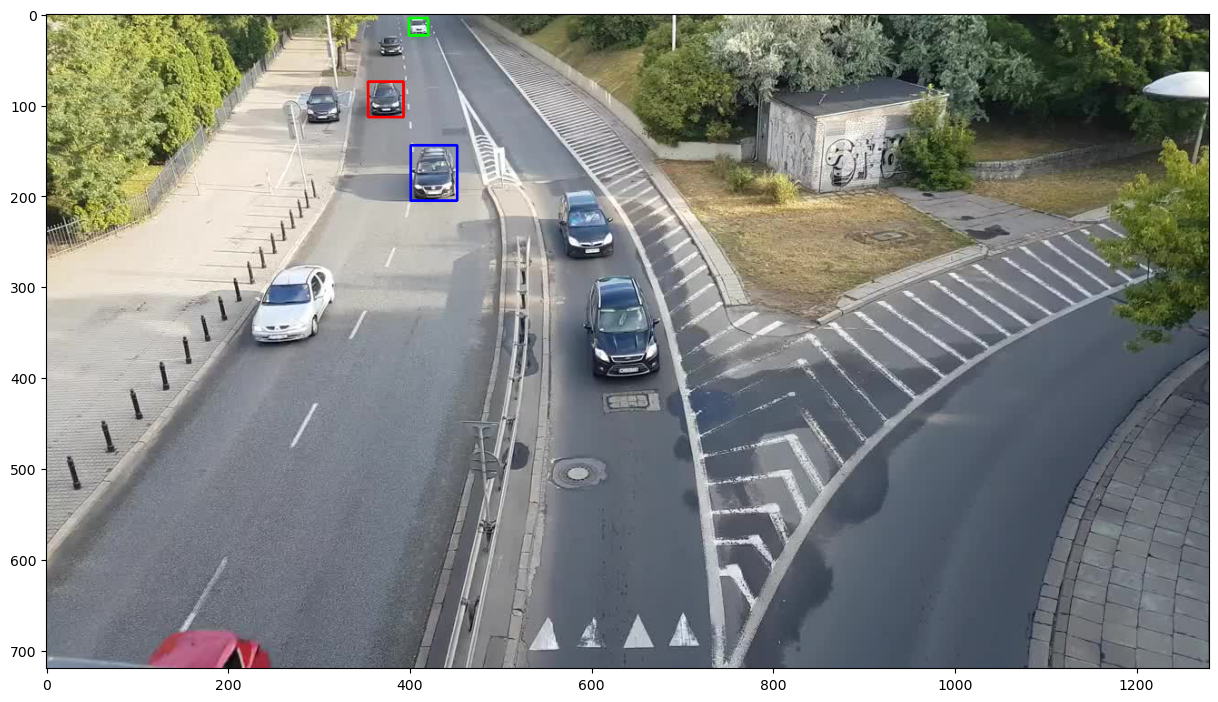

In [43]:
# Load the dataset
folder = './data/traffic_camera'
frames = os.listdir(folder)
frames.sort()

# These cars we wll track
cars = [
    [(399, 4, 420, 23), (0, 255, 0)],
    [(354, 74, 393, 113), (255, 0, 0)],
    [(401, 144, 452, 205), (0, 0, 255)]
]

# Show them on the first frame
img = cv2.imread(os.path.join(folder, frames[0]))
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
for car in cars:
    points, color = car
    x1, y1, x2, y2 = points
    cv2.rectangle(img, (x1, y1), (x2, y2), color, 2)

plt.imshow(img) 

In [44]:
class Track:
    def __init__(self, tracker, points, color, step=1, total=20) -> None:
        self.tracker = tracker
        self.color = color
        self.step = step
        self.total = total
        self.results = []

        # Init tracker
        lt_x,  lt_y, rb_x, rb_y = points
        bbox =  (lt_x, lt_y,  rb_x - lt_x, rb_y - lt_y)
        img = cv2.imread(os.path.join(folder, frames[0]))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        tracker.init(img, bbox)

    def track(self):
        # update tracker for each frame
        for i in range(self.total):
            frame = cv2.imread(os.path.join(folder, frames[i*self.step]))
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            self.last_frame = frame

            ok, bbox = self.tracker.update(frame)
            self.results.append((ok, bbox))

    def show_results_on(self, frame):
        for r in self.results:
            ok, bbox = r
            if not ok: continue

            # Place each bbox on the given frame
            x, y, width, height = bbox
            cv2.rectangle(frame, (x, y), (x+width, y+height), self.color, 1)


In [45]:


def test_tracker(tracker_factory):
    tracks = []

    # Track each car by given tracker
    for car in cars:
        points, color = car
        track = Track(tracker_factory(), points, color)
        track.track()

        tracks.append(track)

    # Merge first and last frames
    img = cv2.imread(os.path.join(folder, frames[0]))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32) + tracks[0].last_frame.astype(np.float32)*0.3

    # Show tracking results
    for track in tracks:
        track.show_results_on(img)

    plt.imshow(img.clip(0, 255).astype(np.uint8))

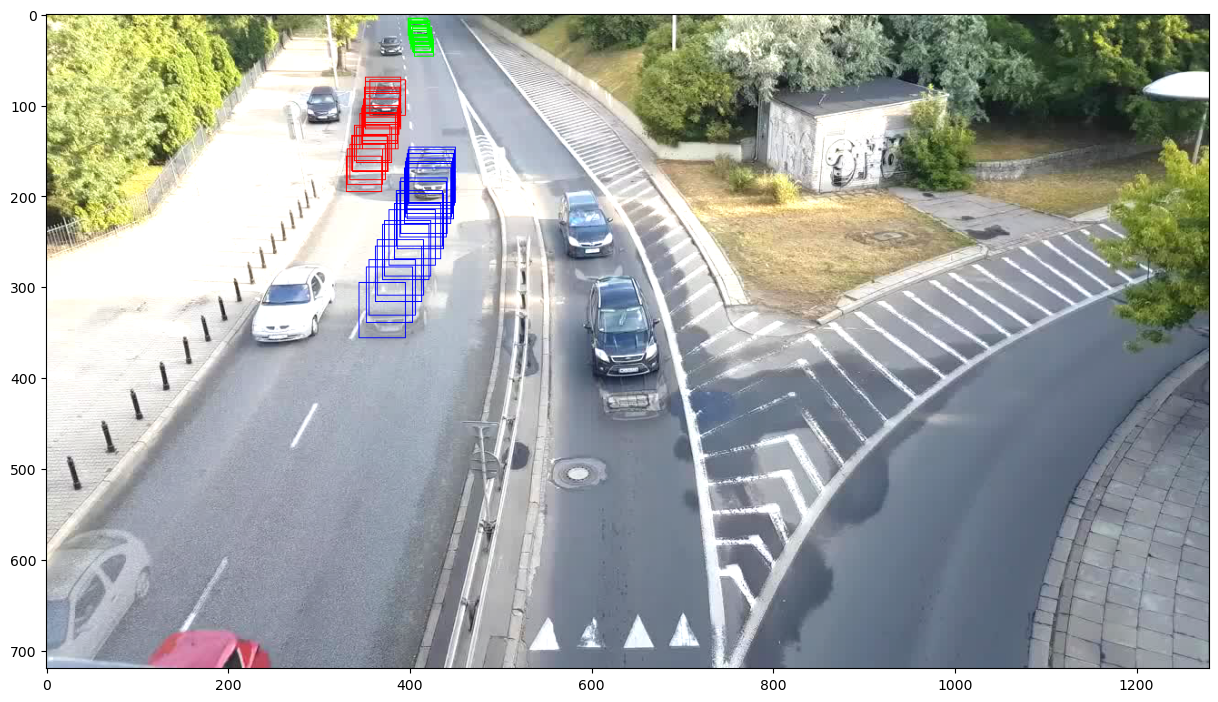

In [46]:
test_tracker(cv2.TrackerMIL_create)

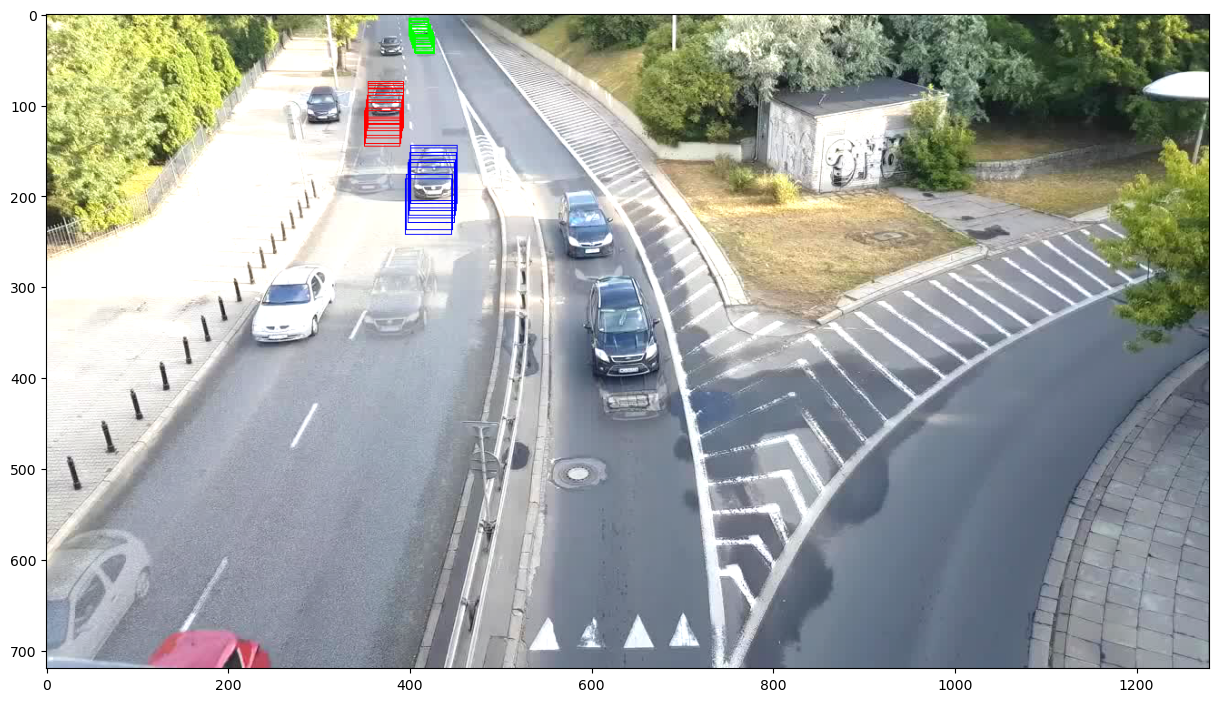

In [47]:
test_tracker(cv2.TrackerKCF_create)

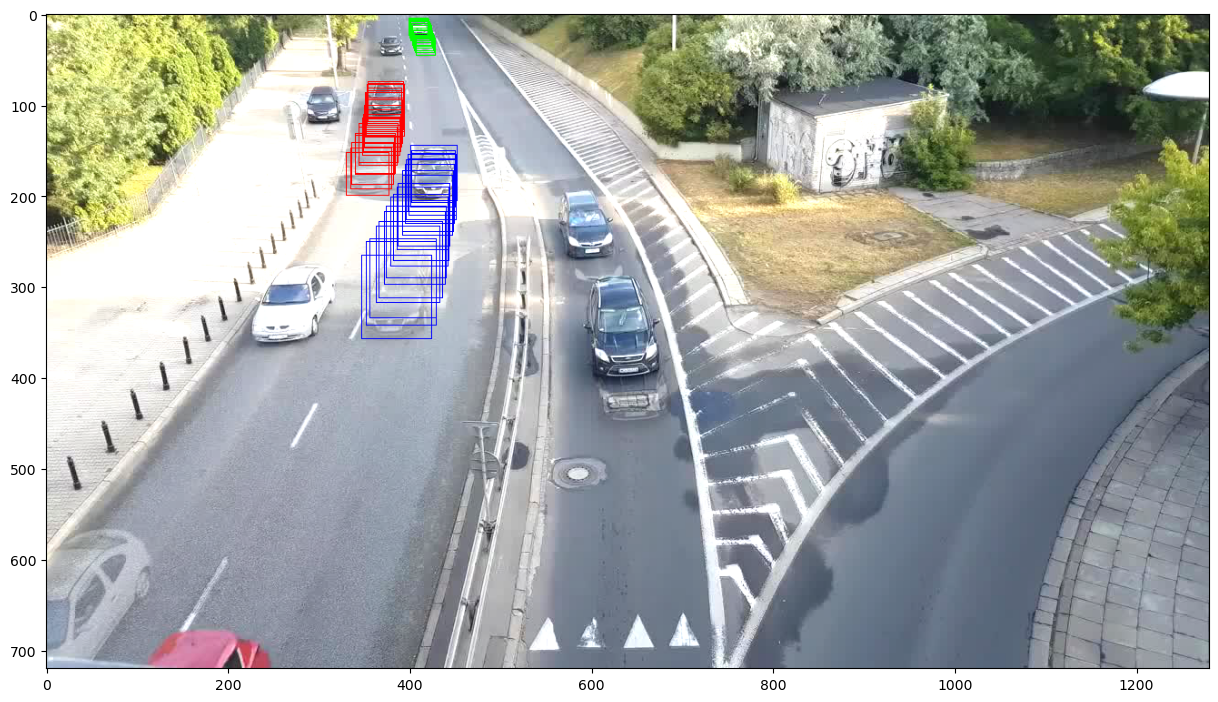

In [48]:
test_tracker(cv2.TrackerCSRT_create)

The MIL tracker works surprisingly pretty good in this case, even that cars becomes closer. There is a jitter of bounding boxes, but it still tracks all cars.

The KCF tracker lose all cars very quickly.

The CSRT tracker is the best! It tracks very accurete every target car and increse its's boundind boxes when car becomes closer to camera. 